## 대출을 승인 받은 날을 기준으로 데이터 셋 분리
- Train
- Test

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [5]:
## Load original data
data_path = "Dataset/loan_data.csv"
data = pd.read_csv(data_path, low_memory=False)

In [6]:
#loan_data 특정 class만 살리고 Charged off -> Defalut class로 바꾸기기
data = data[data['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data['loan_status'].value_counts())

data['loan_status'] = data['loan_status'].replace("Charged Off", "Default")
print('\n',data['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [7]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data['loan_status'] = data['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

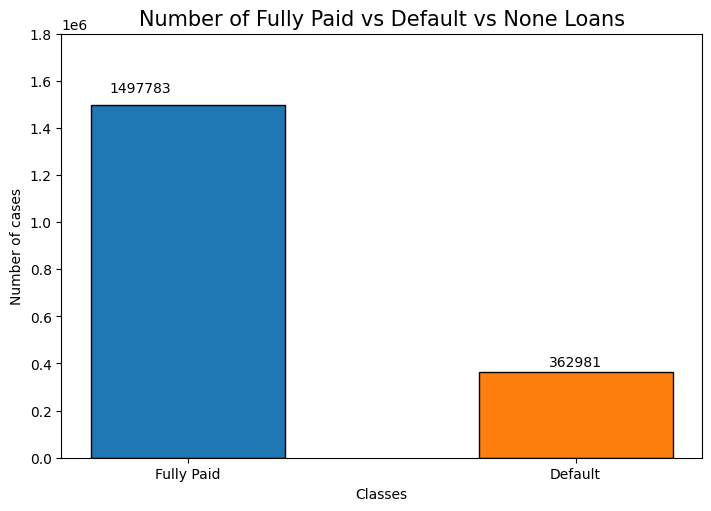

In [10]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [11]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.126339946167981


### Issue_d feature data analysis

In [12]:
data['issue_d'].value_counts()

issue_d
Mar-2016    57558
Oct-2015    45444
Jul-2015    43415
Dec-2015    41307
Oct-2014    38781
            ...  
Aug-2007       33
Sep-2008       32
Jul-2007       30
Sep-2007       18
Jun-2007        1
Name: count, Length: 160, dtype: int64

In [15]:
len(data['issue_d'])

1860764

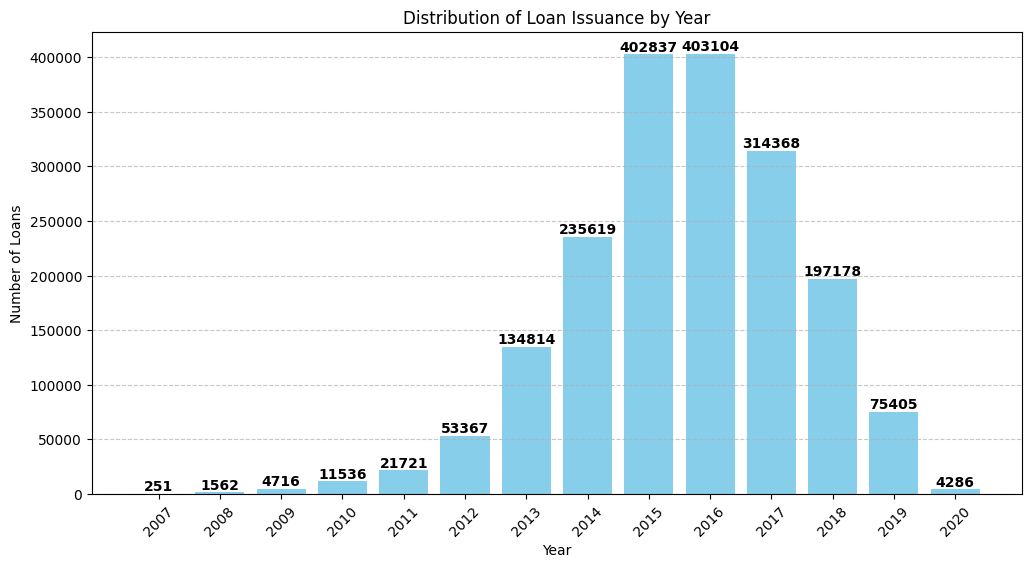

In [14]:
data['issue_d'] = data['issue_d'].str[-4:]

year_counts = data['issue_d'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Year")
plt.ylabel("Number of Loans")
plt.title("Distribution of Loan Issuance by Year")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.show()

In [16]:
data['issue_year'] = data['issue_d'].astype(int)

#2017년 이전으로는 train set, 그 이후는 test set
count_2017_or_before = data[data['issue_year'] <= 2017].shape[0]
count_2018_or_after = data[data['issue_year'] > 2017].shape[0]

# 전체 데이터 수
total_count = count_2017_or_before + count_2018_or_after

# 비율 계산
ratio_2017_or_before = count_2017_or_before / total_count * 100
ratio_2018_or_after = count_2018_or_after / total_count * 100

# 결과 출력
print(f"2017년까지 데이터 수: {count_2017_or_before} ({ratio_2017_or_before:.2f}%)")
print(f"2018년 이후 데이터 수: {count_2018_or_after} ({ratio_2018_or_after:.2f}%)")


2017년까지 데이터 수: 1583895 (85.12%)
2018년 이후 데이터 수: 276869 (14.88%)


### 연도별 데이터에서 데이터 불균형 확인

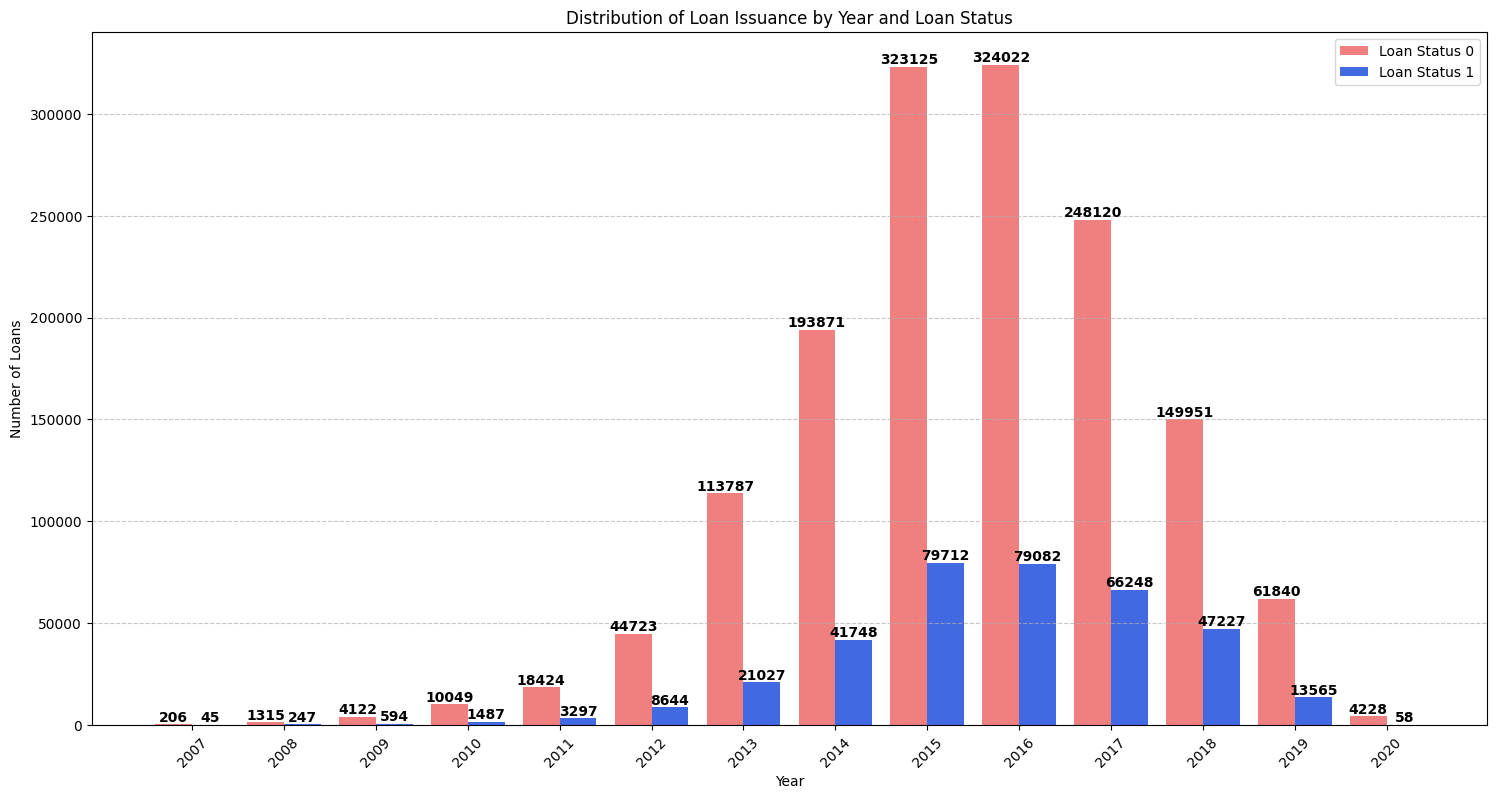

In [18]:
# 연도 추출
data['issue_year'] = data['issue_d'].str[-4:]

# 연도별, loan_status별 개수 계산
year_status_counts = data.groupby(['issue_year', 'loan_status']).size().unstack(fill_value=0)

# 연도 정렬
year_status_counts = year_status_counts.sort_index()

# 바의 너비 설정
bar_width = 0.4
x = np.arange(len(year_status_counts.index))

# 그래프 생성
plt.figure(figsize=(18, 9))
bars1 = plt.bar(x - bar_width/2, year_status_counts[0], width=bar_width, label='Loan Status 0', color='lightcoral')
bars2 = plt.bar(x + bar_width/2, year_status_counts[1], width=bar_width, label='Loan Status 1', color='royalblue')

# 막대 위에 개수 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 축 설정
plt.xlabel("Year")
plt.ylabel("Number of Loans")
plt.title("Distribution of Loan Issuance by Year and Loan Status")
plt.xticks(x, year_status_counts.index, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.show()

In [20]:
# 연도를 정수형으로 변환
data['issue_year'] = data['issue_d'].astype(int)

# 2017년 이전 데이터와 이후 데이터 분리
train_data_before_2017 = data[data['issue_year'] <= 2017]
train_data_after_2017 = data[data['issue_year'] > 2017]

# loan_status별 개수 계산
class_counts_before_2017 = train_data_before_2017['loan_status'].value_counts()
class_counts_after_2017 = train_data_after_2017['loan_status'].value_counts()

# 전체 데이터 개수
total_train_count_before_2017 = class_counts_before_2017.sum()
total_train_count_after_2017 = class_counts_after_2017.sum()

# 2017년 이전 데이터의 클래스 비율 계산
class_0_ratio_before_2017 = (class_counts_before_2017[0] / total_train_count_before_2017) * 100
class_1_ratio_before_2017 = (class_counts_before_2017[1] / total_train_count_before_2017) * 100

# 2018년 이후 데이터의 클래스 비율 계산
class_0_ratio_after_2017 = (class_counts_after_2017[0] / total_train_count_after_2017) * 100
class_1_ratio_after_2017 = (class_counts_after_2017[1] / total_train_count_after_2017) * 100

# 결과 출력
print(" Data before 2017")
print(f"Loan Status 0 ratio: {class_0_ratio_before_2017:.2f}% ({class_counts_before_2017[0]} 개)")
print(f"Loan Status 1 ratio: {class_1_ratio_before_2017:.2f}% ({class_counts_before_2017[1]} 개)")

print("\n Data after 2017")
print(f"Loan Status 0 ratio: {class_0_ratio_after_2017:.2f}% ({class_counts_after_2017[0]} 개)")
print(f"Loan Status 1 ratio: {class_1_ratio_after_2017:.2f}% ({class_counts_after_2017[1]} 개)")


 Data before 2017
Loan Status 0 ratio: 80.92% (1281764 개)
Loan Status 1 ratio: 19.08% (302131 개)

 Data after 2017
Loan Status 0 ratio: 78.02% (216019 개)
Loan Status 1 ratio: 21.98% (60850 개)


In [21]:
train_dataset = data[data['issue_year'] <= 2017]
test_dataset = data[data['issue_year'] > 2017]

In [ ]:
## issue_year feature drop
train_dataset = train_dataset.drop(columns='issue_year')
test_dataset = test_dataset.drop(columns='issue_year')

### train, test dataset preprocessing

In [23]:
#feature drop
drop_features = ['Unnamed: 0','purpose', 'title','id', 'pymnt_plan', 'policy_code','url']
drop_data_leakage = ['total_pymnt','total_pymnt_inv','out_prncp',
                     'out_prncp_inv','recoveries','collection_recovery_fee',
                     'last_pymnt_d','last_pymnt_amnt','issue_d',
                     'next_pymnt_d','last_credit_pull_d','total_rec_prncp', 
                    'total_rec_int','total_rec_late_fee','last_fico_range_high',
                    'last_fico_range_low'
                     ]
train_dataset = train_dataset.drop(columns=drop_features + drop_data_leakage)
test_dataset = test_dataset.drop(columns=drop_features + drop_data_leakage)

In [24]:
# Train
train_data_x = train_dataset.drop(columns='loan_status')
train_data_y = train_dataset[['loan_status']]

print(len(train_dataset.columns))

# Test
test_data_x = test_dataset.drop(columns='loan_status')
test_data_y = test_dataset[['loan_status']]

print(len(test_dataset.columns))

119
119


In [25]:
#data 타입 변환
#퍼센트를 float형태로 바꾸기
def converting_cat_to_num(x):
    if not isinstance(x,str):
        return x  
    return float(x.split("%")[0].lstrip())

#zip code 뒤에 x 2개 빼고 float형 변환
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return int(x[0:-2])

def to_data_tranfromer(x):
    if not isinstance(x, str):
        return np.nan
    date = x.split('-')
    if len(date) != 2:
        return np.nan  # 예상치 못한 포맷 처리
    month, year = date[0], date[1]
    return int(year + enum.get(month, "00"))  # "YYYYMM" 형식으로 변환

## 시간 데이터 확인
to_data_features = ["earliest_cr_line",  \
                    "sec_app_earliest_cr_line", "hardship_start_date",\
                    "hardship_end_date", "payment_plan_start_date"]

enum = {'Jan':"01", 'Feb':"02", 'Mar':"03", 
        'Apr':"04", 'May':"05", 'Jun':"06",
        'Jul':"07", 'Aug':"08", 
        'Sep':"09", 'Oct':"10", 
        'Nov':"11", 'Dec':"12"}

# Train
# Converting numerically data stored as categorical
train_data_x['int_rate'] = train_data_x['int_rate'].map(converting_cat_to_num)
train_data_x['revol_util'] = train_data_x['revol_util'].map(converting_cat_to_num)

# Filtering the zip code
train_data_x["zip_code"] = train_data_x["zip_code"].map(filter_zip_code)


for name in to_data_features:
    train_data_x[name] = train_data_x[name].map(to_data_tranfromer)

print("Successfully converted!")

# Test
test_data_x['int_rate'] = test_data_x['int_rate'].map(converting_cat_to_num)
test_data_x['revol_util'] = test_data_x['revol_util'].map(converting_cat_to_num)

# Filtering the zip code
test_data_x["zip_code"] = test_data_x["zip_code"].map(filter_zip_code)


for name in to_data_features:
    test_data_x[name] = test_data_x[name].map(to_data_tranfromer)

print("Successfully converted!")

Successfully converted!
Successfully converted!


In [26]:
# Train
# Analyzing the numerical data generally
number_of_missing_values = {}
percentage_of_missing_values = {}
number_of_duplicate_elements = {}
ratio_of_duplicates = {}

# Check columns
columns_name_to_check = train_data_x.columns
#columns_name_to_check = columns_name_to_check.drop("loan_status")
# Calculating
for name in columns_name_to_check:
    number_of_nulls = train_data_x[name].isnull().sum()
    number_of_missing_values[name] = number_of_nulls
    percentage_of_missing_values[name] = (number_of_nulls/len(train_data_x[name]))*100
    
for name in columns_name_to_check:
    number_of_duplicate_elements[name] = (train_data_x[name].count() - train_data_x[name].nunique())

for name in columns_name_to_check:
    ratio_of_duplicates[name] = number_of_duplicate_elements[name]/train_data_x[name].count()    

# Restructuring the Gathered Information
reassemble_data = {
                  "Attribute Names" : list(ratio_of_duplicates.keys()),
                  "Number of Missing Values" : list(number_of_missing_values.values()),
                  "Missing Values %" : list(percentage_of_missing_values.values()),
                  "Number of Duplicates" : list(number_of_duplicate_elements.values()),
                  "Ratio of Duplicates" : list(ratio_of_duplicates.values())
                  }

statistics_about_data =  pd.DataFrame(reassemble_data)

# Visualizing the Data
statistics_sorted = statistics_about_data.sort_values(by = 'Missing Values %') 
statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
.background_gradient(axis=0) #subset='Number of Duplicates')

,Attribute Names,Number of Missing Values,Missing Values %,Number of Duplicates,Ratio of Duplicates
0,loan_amnt,0,0.000000,1582332,0.999013
35,acc_now_delinq,0,0.000000,1583887,0.999995
31,application_type,0,0.000000,1583893,0.999999
28,initial_list_status,0,0.000000,1583893,0.999999
27,total_acc,0,0.000000,1583750,0.999908
25,revol_bal,0,0.000000,1494718,0.943698
24,pub_rec,0,0.000000,1583854,0.999974
23,open_acc,0,0.000000,1583810,0.999946
19,fico_range_high,0,0.000000,1583855,0.999975
18,fico_range_low,0,0.000000,1583855,0.999975


In [27]:
#Missing value ratio가 5를 넘어가는 것들은 모두 drop
features_to_remove = list(statistics_sorted.loc[(statistics_sorted["Missing Values %"] > 5)]["Attribute Names"])
print(f"List of features that need to be removed: {len(features_to_remove)}")

for  name in features_to_remove:
    train_data_x.drop(labels=name, axis=1, inplace=True)

print("Non-high presence features have been deleted successfully!")

List of features that need to be removed: 53
Non-high presence features have been deleted successfully!


In [28]:
# Analyzing the numerical data generally
number_of_missing_values = {}
percentage_of_missing_values = {}
number_of_duplicate_elements = {}
ratio_of_duplicates = {}

# Check columns
columns_name_to_check = test_data_x.columns
#columns_name_to_check = columns_name_to_check.drop("loan_status")
# Calculating
for name in columns_name_to_check:
    number_of_nulls = test_data_x[name].isnull().sum()
    number_of_missing_values[name] = number_of_nulls
    percentage_of_missing_values[name] = (number_of_nulls/len(test_data_x[name]))*100
    
for name in columns_name_to_check:
    number_of_duplicate_elements[name] = (test_data_x[name].count() - test_data_x[name].nunique())

for name in columns_name_to_check:
    ratio_of_duplicates[name] = number_of_duplicate_elements[name]/test_data_x[name].count()    

# Restructuring the Gathered Information
reassemble_data = {
                  "Attribute Names" : list(ratio_of_duplicates.keys()),
                  "Number of Missing Values" : list(number_of_missing_values.values()),
                  "Missing Values %" : list(percentage_of_missing_values.values()),
                  "Number of Duplicates" : list(number_of_duplicate_elements.values()),
                  "Ratio of Duplicates" : list(ratio_of_duplicates.values())
                  }

statistics_about_data =  pd.DataFrame(reassemble_data)

# Visualizing the Data
statistics_sorted = statistics_about_data.sort_values(by = 'Missing Values %') 
statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
.background_gradient(axis=0) #subset='Number of Duplicates')

,Attribute Names,Number of Missing Values,Missing Values %,Number of Duplicates,Ratio of Duplicates
0,loan_amnt,0,0.000000,275315,0.994387
62,mo_sin_rcnt_tl,0,0.000000,276702,0.999397
61,mo_sin_rcnt_rev_tl_op,0,0.000000,276621,0.999104
60,mo_sin_old_rev_tl_op,0,0.000000,276169,0.997472
57,chargeoff_within_12_mths,0,0.000000,276861,0.999971
53,acc_open_past_24mths,0,0.000000,276829,0.999856
52,inq_last_12m,0,0.000000,276826,0.999845
51,total_cu_tl,0,0.000000,276818,0.999816
50,inq_fi,0,0.000000,276839,0.999892
49,total_rev_hi_lim,0,0.000000,271035,0.978929


In [29]:
#Missing value ratio가 5를 넘어가는 것들은 모두 drop
features_to_remove = list(statistics_sorted.loc[(statistics_sorted["Missing Values %"] > 5)]["Attribute Names"])
print(f"List of features that need to be removed: {len(features_to_remove)}")

for  name in features_to_remove:
    test_data_x.drop(labels=name, axis=1, inplace=True)

print("Non-high presence features have been deleted successfully!")

List of features that need to be removed: 38
Non-high presence features have been deleted successfully!


In [31]:
print(features_to_remove)

['emp_length', 'mths_since_recent_inq', 'emp_title', 'il_util', 'mths_since_last_delinq', 'mths_since_recent_revol_delinq', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'mths_since_last_record', 'annual_inc_joint', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'dti_joint', 'sec_app_fico_range_high', 'sec_app_revol_util', 'verification_status_joint', 'hardship_amount', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'orig_projected_additional_accrued_interest', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_type', 'hardship_loan_status']


In [30]:
print(f"The number of Train features : {len(train_data_x.columns)}\nThe target feature : {train_data_y.columns}")
print(f"The number of Test features : {len(test_data_x.columns)}\nThe target feature : {test_data_y.columns}")

The number of Train features : 65
The target feature : Index(['loan_status'], dtype='object')
The number of Test features : 80
The target feature : Index(['loan_status'], dtype='object')
